In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
data = pd.read_csv("data/Fish.csv")

In [2]:
data.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [3]:
data.isna().sum()

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64

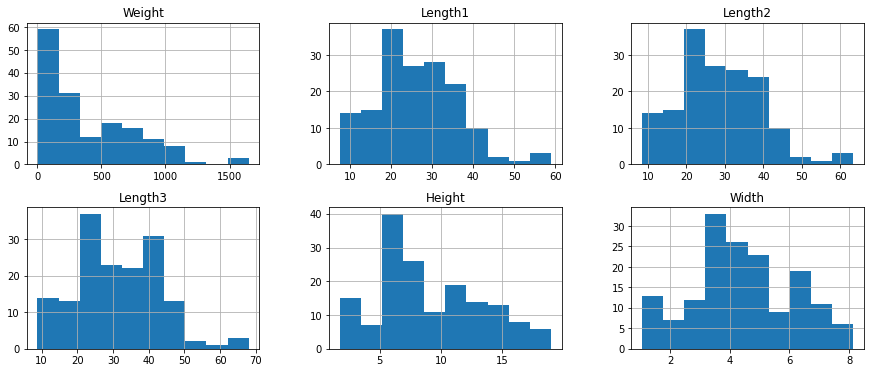

In [4]:
data_num = data.drop(columns=["Species"])

fig, axes = plt.subplots(len(data_num.columns)//3, 3, figsize=(15, 6))
i = 0
for triaxis in axes:
    for axis in triaxis:
        data_num.hist(column = data_num.columns[i], ax=axis)
        i = i+1

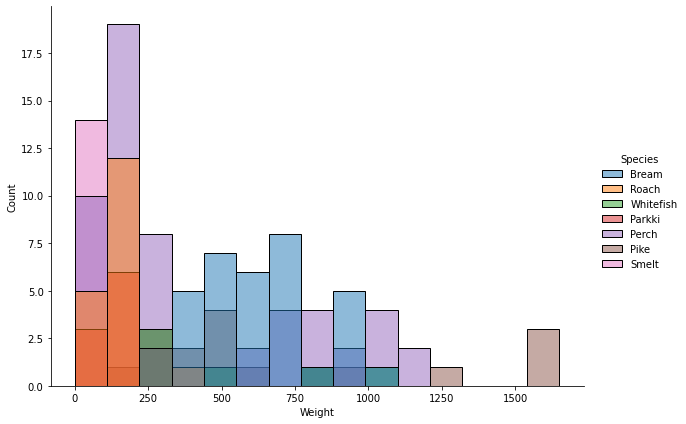

In [5]:
sns.displot(
  data=data,
  x="Weight",
  hue="Species",
  kind="hist",
  height=6,
  aspect=1.4,
  bins=15
)
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
data_cleaned =   data.drop("Weight", axis=1)
y = data['Weight']
x_train, x_test, y_train, y_test = train_test_split(data_cleaned,y, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
# label encoder
label_encoder = LabelEncoder()
x_train['Species'] = label_encoder.fit_transform(x_train['Species'].values)
x_test['Species'] = label_encoder.transform(x_test['Species'].values)

(127, 6) (32, 6) (127,) (32,)


In [8]:
def evauation_model(pred, y_val):
    score_MSE = round(mean_squared_error(pred, y_val),2)
    score_MAE = round(mean_absolute_error(pred, y_val),2)
    score_r2score = round(r2_score(pred, y_val),2)
    return score_MSE, score_MAE, score_r2score
def models_score(model_name, train_data, y_train, val_data,y_val):
    model_list = ["Decision_Tree","Random_Forest","XGboost_Regressor"]
    #model_1
    if model_name=="Decision_Tree":
        reg = DecisionTreeRegressor(random_state=42)
    #model_2
    elif model_name=="Random_Forest":
        reg = RandomForestRegressor(random_state=42)
        
    #model_3
    elif model_name=="XGboost_Regressor":
        reg = xgb.XGBRegressor(objective="reg:squarederror",random_state=42,)
    else:
        print("please enter correct regressor name")
        
    if model_name in model_list:
        reg.fit(train_data,y_train)
        pred = reg.predict(val_data)
        score_MSE, score_MAE, score_r2score = evauation_model(pred,y_val)
        return round(score_MSE,2), round(score_MAE,2), round(score_r2score,2)
model_list = ["Decision_Tree","Random_Forest","XGboost_Regressor"]
result_scores = []
for model in model_list:
    score = models_score(model, x_train, y_train, x_test, y_test)
    result_scores.append((model, score[0], score[1],score[2]))
    print(model,score)

Decision_Tree (7005.89, 48.71, 0.95)
Random_Forest (4659.44, 44.66, 0.97)
XGboost_Regressor (5151.54, 41.05, 0.96)


In [11]:
df_result_scores = pd.DataFrame(result_scores,columns=["model","mse","mae","r2score"])
df_result_scores

,model,mse,mae,r2score
0,Decision_Tree,7005.89,48.71,0.95
1,Random_Forest,4659.44,44.66,0.97
2,XGboost_Regressor,5151.54,41.05,0.96


In [13]:
from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from sklearn.model_selection import cross_val_score
num_estimator = [100,150,200,250]

space=  {'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 30,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.choice("n_estimators", num_estimator),
    }

def hyperparameter_tuning(space):
    model=xgb.XGBRegressor(n_estimators = space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = int(space['reg_alpha']) , min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'], objective="reg:squarederror")
    
    score_cv = cross_val_score(model, x_train, y_train, cv=5, scoring="neg_mean_absolute_error").mean()
    return {'loss':-score_cv, 'status': STATUS_OK, 'model': model}


trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            trials=trials)

print(best)

100%|██████████| 200/200 [04:00<00:00,  1.20s/trial, best loss: 37.85483239687406]
{'colsample_bytree': 0.7870045159447576, 'gamma': 7.770816621139947, 'max_depth': 7.0, 'min_child_weight': 0.0, 'n_estimators': 0, 'reg_alpha': 62.0, 'reg_lambda': 0.3421829597411876}


In [14]:
best['max_depth'] = int(best['max_depth']) # convert to int
best["n_estimators"] = num_estimator[best["n_estimators"]] #assing value based on index
reg = xgb.XGBRegressor(**best)
reg.fit(x_train,y_train)
pred = reg.predict(x_test)
score_MSE, score_MAE, score_r2score = evauation_model(pred,y_test) 
to_append = ["XGboost_hyper_tuned",score_MSE, score_MAE, score_r2score]
df_result_scores.loc[len(df_result_scores)] = to_append
df_result_scores

,model,mse,mae,r2score
0,Decision_Tree,7005.89,48.71,0.95
1,Random_Forest,4659.44,44.66,0.97
2,XGboost_Regressor,5151.54,41.05,0.96
3,XGboost_hyper_tuned,2622.74,37.17,0.98


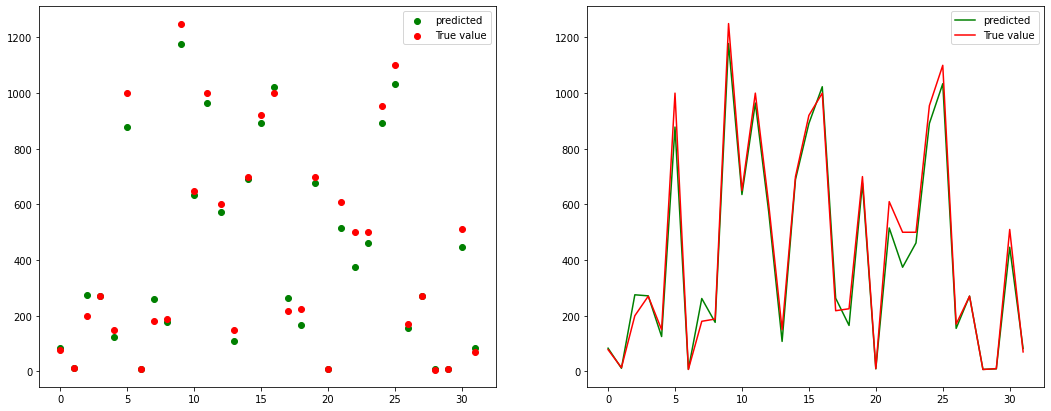

In [15]:
# winner
reg = xgb.XGBRegressor(**best)
reg.fit(x_train,y_train)
pred = reg.predict(x_test)
plt.figure(figsize=(18,7))
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.scatter(range(0,len(x_test)), pred,color="green",label="predicted")
plt.scatter(range(0,len(x_test)), y_test,color="red",label="True value")
plt.legend()

plt.subplot(1, 2, 2) # index 2
plt.plot(range(0,len(x_test)), pred,color="green",label="predicted")
plt.plot(range(0,len(x_test)), y_test,color="red",label="True value")
plt.legend()
plt.show()